In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

### Old MNIST Data


In [2]:
# # MNIST Data
# import hashlib
# import os
# import typing
# from urllib.error import HTTPError, URLError
# from urllib.request import urlretrieve


# def download_mnist() -> str:
#     """Code to download mnist originates from keras/datasets:

#     https://github.com/keras-team/keras/blob/v2.15.0/keras/datasets/mnist.py#L25-L86
#     """
#     origin_folder = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
#     path = _get_file(
#         "mnist.npz",
#         origin=origin_folder + "mnist.npz",
#         file_hash=("731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1"),
#     )

#     return path


# def _get_file(
#     fname: str,
#     origin: str,
#     file_hash: typing.Optional[str] = None,
# ):
#     cache_dir = os.path.join(os.path.expanduser("~"), ".keras")
#     datadir_base = os.path.expanduser(cache_dir)
#     if not os.access(datadir_base, os.W_OK):
#         datadir_base = os.path.join("/tmp", ".keras")
#     datadir = os.path.join(datadir_base, "datasets")
#     os.makedirs(datadir, exist_ok=True)

#     fname = os.fspath(fname) if isinstance(fname, os.PathLike) else fname
#     fpath = os.path.join(datadir, fname)

#     download = False
#     if os.path.exists(fpath):
#         if file_hash is not None and not _validate_file(fpath, file_hash):
#             download = True
#     else:
#         download = True

#     if download:
#         try:
#             error_msg = "URL fetch failure on {}: {} -- {}"
#             try:
#                 urlretrieve(origin, fpath)
#             except HTTPError as e:
#                 raise Exception(error_msg.format(origin, e.code, e.msg)) from e
#             except URLError as e:
#                 raise Exception(error_msg.format(origin, e.errno, e.reason)) from e
#         except (Exception, KeyboardInterrupt):
#             if os.path.exists(fpath):
#                 os.remove(fpath)
#             raise

#         if (
#             os.path.exists(fpath)
#             and file_hash is not None
#             and not _validate_file(fpath, file_hash)
#         ):
#             raise ValueError(
#                 "Incomplete or corrupted file detected. "
#                 f"The sha256 file hash does not match the provided value "
#                 f"of {file_hash}.",
#             )
#     return fpath


# def _validate_file(fpath, file_hash, chunk_size=65535):
#     hasher = hashlib.sha256()
#     with open(fpath, "rb") as fpath_file:
#         for chunk in iter(lambda: fpath_file.read(chunk_size), b""):
#             hasher.update(chunk)

#     return str(hasher.hexdigest()) == str(file_hash)


# mnist_path = download_mnist()

In [3]:
# # Create
# rng = np.random.default_rng(33)
# size = 22

# with np.load(mnist_path, allow_pickle=True) as fp:
#     images, labels = fp["x_train"][:size], fp["y_train"][:size]

# dup_images = deepcopy(images[:8]).astype("float64")
# dup_images[:, :25, :25] = images[:8, 3:, 3:]
# dup_images[:, 25:, 25:] = images[:8, :3, :3]

# test_imgs = np.concatenate([images, dup_images])
# test_imgs /= 255

# rng.shuffle(test_imgs)

# data = test_imgs.reshape((test_imgs.shape[0], -1))
# print(data.shape)

In [4]:
# r = np.random.randint(0, len(images))
# plt.imshow(images[r])

### Blob data


(10, 2)


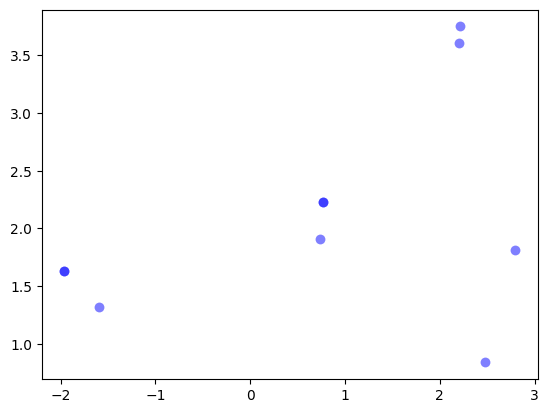

In [5]:
import sklearn.datasets as dsets

plot_kwds = {"alpha": 0.5, "s": 50, "linewidths": 0}

# moons, _ = dsets.make_moons(n_samples=50, noise=0.1)
blobs, _ = dsets.make_blobs(  # type: ignore
    n_samples=10,
    centers=[(-1.5, 1.8), (-1, 3), (0.8, 2.1), (2.8, 1.5), (2.5, 3.5)],  # type: ignore
    cluster_std=0.3,
    random_state=33,
)
# test_data = np.vstack([moons, blobs])
test_data = blobs
test_data[2] = test_data[4]
test_data[3] = test_data[6] + 1e-5

print(test_data.shape)

# Create scatter plot
plt.scatter(test_data.T[0], test_data.T[1], color="b", **plot_kwds)

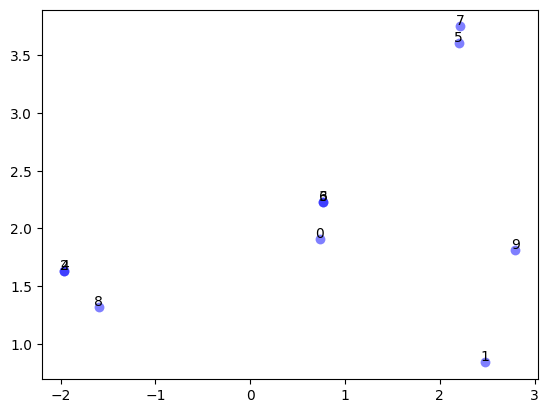

In [6]:
# Create scatter plot
plt.scatter(test_data.T[0], test_data.T[1], color="b", **plot_kwds)

# Annotate each point in the scatter plot
for i, (x, y) in enumerate(test_data):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 1), ha="center")

### Functions


In [7]:
def create_clusters(arr):
    max_clusters = 1
    max_levels = 1
    clusters = {}
    for i in range(len(arr)):
        level = 1
        cluster_num = max_clusters
        distance = 0
        count = 0
        sample_added = []
        if arr[i, 0] in clusters:
            cluster_num = min([cluster_num, clusters[arr[i, 0]]["cluster_num"]])
            left_level = max([level, clusters[arr[i, 0]]["level"] + 1])
            distance += clusters[arr[i, 0]]["total_dist"]
            count += clusters[arr[i, 0]]["count"]
        else:
            sample_added.append(int(arr[i, 0]))

        if arr[i, 1] in clusters:
            cluster_num = min([cluster_num, clusters[arr[i, 1]]["cluster_num"]])
            right_level = max([level, clusters[arr[i, 1]]["level"] + 1])
            distance += clusters[arr[i, 1]]["total_dist"]
            count += clusters[arr[i, 1]]["count"]
        else:
            sample_added.append(int(arr[i, 1]))

        if arr[i, 0] in clusters and arr[i, 1] in clusters:
            if cluster_num == clusters[arr[i, 0]]["cluster_num"]:
                level = left_level
            elif cluster_num == clusters[arr[i, 1]]["cluster_num"]:
                level = right_level
        elif arr[i, 0] in clusters:
            level = left_level
        elif arr[i, 1] in clusters:
            level = right_level

        count += 1
        distance += arr[i, 2]

        clusters[arr[i, -1]] = {
            "cluster_num": cluster_num,
            "level": level,
            "total_dist": distance,
            "count": count,
            "avg_dist": distance / count,
            "samples_added": sample_added,
            "sample_dist": arr[i, 2],
        }

        if cluster_num == max_clusters and i < len(arr) - 1:
            max_clusters += 1

        if level > max_levels:
            max_levels = level

    return clusters

In [8]:
def create_clusters_opt(arr):
    max_clusters = 1
    max_levels = 1
    clusters = {}

    for i, arr_i in enumerate(arr):
        level = 1
        cluster_num = max_clusters

        left_count = 0
        right_count = 0
        merged = False

        new_sample = []
        sample_dist = np.array([arr_i[2]], dtype=np.float16)

        arr_0 = int(arr_i[0])
        arr_1 = int(arr_i[1])

        # Cluster left
        cluster_0 = clusters.get(arr_0)
        if cluster_0 is None:
            new_sample.append(arr_0)
        else:
            left_cluster = cluster_0["cluster_num"]
            level = max([level, cluster_0["level"] + 1])
            left_count = cluster_0["count"]
            left_sample = cluster_0["samples"]
            sample_dist = np.concatenate([cluster_0["sample_dist"], sample_dist])

        # Cluster right
        cluster_1 = clusters.get(arr_1)
        if cluster_1 is None:
            new_sample.append(arr_1)
        else:
            right_cluster = cluster_1["cluster_num"]
            level = max([level, cluster_1["level"] + 1])
            right_count = cluster_1["count"]
            right_sample = cluster_1["samples"]
            sample_dist = np.concatenate([cluster_1["sample_dist"], sample_dist])

        # Add clusters to samples
        if cluster_0 and cluster_1:
            if left_count > right_count:
                samples = np.concatenate([left_sample, right_sample])
            else:
                samples = np.concatenate([right_sample, left_sample])
            cluster_num = min([left_cluster, right_cluster])
            merged = max([left_cluster, right_cluster])
        elif cluster_0:
            samples = np.concatenate([left_sample, new_sample])
            cluster_num = left_cluster
        elif cluster_1:
            samples = np.concatenate([right_sample, new_sample])
            cluster_num = right_cluster
        else:
            samples = np.array(new_sample, dtype=np.int32)

        dist_avg = np.mean(sample_dist)
        dist_std = np.std(sample_dist) if sample_dist.shape[0] > 1 else 0

        clusters[arr_i[-1]] = {
            "cluster_num": cluster_num,
            "level": level,
            "count": samples.shape[0],
            "avg_dist": dist_avg,
            "dist_std": dist_std,
            "samples": samples,  # adjusted this to keep tract of all samples in the list
            "sample_dist": sample_dist,
            "cluster_merged": merged,
        }

        if cluster_num == max_clusters:
            max_clusters += 1

        max_levels = max(max_levels, level)
    max_clusters -= 1
    max_levels -= 1  # Because we don't care about the last level where everything is in a single cluster

    return clusters, max_levels, max_clusters

In [9]:
def reorganize_clusters(clusters, min_num_samples_per_cluster=7):
    """
    Reorganize the clusters dictionary to be nested by level, then by cluster_num,
    and include avg_dist, sample_dist, and samples within each level.

    Parameters:
    - clusters: A dictionary containing the original clusters information.

    Returns:
    - new_structure: A dictionary reorganized by level,
                    then by cluster_num, with details.
    """
    new_structure = {}
    merge_clusters = {"merge": {}, "likely_merge": {}, "no_merge": {}}
    outliers = []
    possible_outliers = []

    for _, info in clusters.items():
        # Extract necessary information
        cluster_num = info["cluster_num"]
        level = info["level"]
        samples = info["samples"]
        avg_dist = info["avg_dist"]
        dist_std = info["dist_std"]
        samp_dist = info["sample_dist"][-1]
        merged = info["cluster_merged"]

        out1 = avg_dist + dist_std
        out2 = out1 + dist_std

        # Initialize the structure if not present
        if level not in new_structure:
            new_structure[level] = {}

        if cluster_num not in new_structure[level]:
            new_structure[level][cluster_num] = {
                "samples": samples,
                "avg_dist": avg_dist,
                "dist_std": dist_std,
                "added_samp_dist": samp_dist,
                "outside_1-std": samp_dist > out1,
                "outside_2-std": samp_dist > out2,
                "contains_clusters": [],
            }

            if merged:
                for i in range(2, level):
                    if merged not in new_structure[i]:
                        new_structure[i][merged] = {
                            "samples": new_structure[i - 1][merged]["samples"],
                            "avg_dist": new_structure[i - 1][merged]["avg_dist"],
                            "dist_std": new_structure[i - 1][merged]["dist_std"],
                            "contains_clusters": new_structure[i - 1][merged]["contains_clusters"],
                        }
                    if cluster_num not in new_structure[i]:
                        new_structure[i][cluster_num] = {
                            "samples": new_structure[i - 1][cluster_num]["samples"],
                            "avg_dist": new_structure[i - 1][cluster_num]["avg_dist"],
                            "dist_std": new_structure[i - 1][cluster_num]["dist_std"],
                            "contains_clusters": new_structure[i - 1][cluster_num]["contains_clusters"],
                        }

                if samp_dist > out2:
                    if len(samples) < min_num_samples_per_cluster:
                        if cluster_num not in merge_clusters["likely_merge"]:
                            merge_clusters["likely_merge"][cluster_num] = {level: (merged, "low sample count")}
                        if level not in merge_clusters["likely_merge"][cluster_num]:
                            merge_clusters["likely_merge"][cluster_num][level] = (
                                merged,
                                "low sample count",
                            )
                    else:
                        if cluster_num not in merge_clusters["no_merge"]:
                            merge_clusters["no_merge"][cluster_num] = {level: merged}
                        if level not in merge_clusters["no_merge"][cluster_num]:
                            merge_clusters["no_merge"][cluster_num][level] = merged
                elif samp_dist > out1 and len(samples) >= min_num_samples_per_cluster:
                    if cluster_num not in merge_clusters["likely_merge"]:
                        merge_clusters["likely_merge"][cluster_num] = {level: merged}
                    if level not in merge_clusters["likely_merge"][cluster_num]:
                        merge_clusters["likely_merge"][cluster_num][level] = merged
                else:
                    if cluster_num not in merge_clusters["merge"]:
                        merge_clusters["merge"][cluster_num] = {level: merged}
                    if level not in merge_clusters["merge"][cluster_num]:
                        merge_clusters["merge"][cluster_num][level] = merged

            else:
                if samp_dist > out2:
                    outliers.append((samples[-1], cluster_num, level))
                elif (
                    samp_dist > out1
                    and len(samples) >= min_num_samples_per_cluster
                    and cluster_num in merge_clusters["likely_merge"]
                ):
                    check = sorted(merge_clusters["likely_merge"][cluster_num].keys())
                    if level > check[0]:
                        possible_outliers.append((samples[-1], cluster_num, level))

            if level != 1:
                new_structure[level][cluster_num]["contains_clusters"] = deepcopy(
                    new_structure[level - 1][cluster_num]["contains_clusters"]
                )
                if merged:
                    prev_cluster_mergings = deepcopy(new_structure[level - 1][merged]["contains_clusters"])
                    if prev_cluster_mergings:
                        new_structure[level][cluster_num]["contains_clusters"].extend(prev_cluster_mergings)
                    new_structure[level][cluster_num]["contains_clusters"].append(merged)

    return new_structure, merge_clusters, outliers, possible_outliers

In [10]:
def extend_linkage(Z):
    """
    Add a column to the linkage matrix Z which tracks the new id assigned
    for each row for tracking clusters.

    Parameters:
    - Z: linkage matrix

    Returns:
    - arr: linkage matrix with adjusted shape, new shape (Z.shape[0], Z.shape[1]+1)
    """
    # Adjusting linkage matrix to accommodate renumbering
    arr = np.zeros((Z.shape[0], Z.shape[1] + 1))
    arr[:, :-1] = Z.copy()
    arr[:, -1] = np.arange(Z.shape[0] + 1, 2 * Z.shape[0] + 1)

    # Sort by decreasing distance, then by increasing new_size
    # arr = arr[arr[:, 2].argsort()[::-1]]
    # arr = arr[arr[:, -2].argsort(kind="stable")]

    return arr

In [11]:
def get_cluster_distance(clusters, max_clusters, max_levels, square_distance_matrix):
    # this is the cluster distance matrix
    cluster_matrix = np.full((max_levels, max_clusters, max_clusters), -1.0, dtype=np.float32)

    for level, cluster_set in clusters.items():
        if level <= max_levels:
            # print(f"\t\tLevel {level-1}")
            cluster_ids = sorted(cluster_set.keys())
            # print("List of ids: ", cluster_ids)
            for i, cluster_id in enumerate(cluster_ids):
                cluster_id = cluster_id
                # print("Selected cluster ", cluster_id)
                cluster_matrix[level - 1, cluster_id - 1, cluster_id - 1] = clusters[level][cluster_id]["avg_dist"]
                for int_id in range(i + 1, len(cluster_ids)):
                    compare_id = cluster_ids[int_id]
                    # print(f"\tComparing cluster {compare_id}")
                    sample_a = clusters[level][cluster_id]["samples"]
                    sample_b = clusters[level][compare_id]["samples"]
                    # print(f"\t\tSamples A: {sample_a}, Samples B: {sample_b}")
                    min_mat = square_distance_matrix[np.ix_(sample_a, sample_b)].min()
                    cluster_matrix[level - 1, cluster_id - 1, compare_id - 1] = min_mat
                    cluster_matrix[level - 1, compare_id - 1, cluster_id - 1] = min_mat

    return cluster_matrix

In [12]:
def filter_outliers(outliers, last_good_merge_levels):
    filtered_outliers = []
    for outlier in outliers:
        sample_number, outer_cluster, level = outlier
        if outer_cluster in last_good_merge_levels and level >= last_good_merge_levels[outer_cluster] + 1:
            filtered_outliers.append(sample_number)
    return filtered_outliers

In [13]:
def get_duplicates(square_distance_matrix, dedup_std):
    diag_mask = np.ones(square_distance_matrix.shape, dtype=bool)
    np.fill_diagonal(diag_mask, 0)  # this needs to change to be a mask of the diagonal
    diag_mask = np.triu(diag_mask)

    exact_mask = square_distance_matrix < (np.mean(dedup_std) / 100)
    exact_indices = np.nonzero(exact_mask & diag_mask)
    exact_dedup = list(zip(exact_indices[0], exact_indices[1]))

    possible_mask = square_distance_matrix < np.mean(dedup_std)
    possible_indices = np.nonzero(possible_mask & diag_mask & ~exact_mask)
    possible_dedup = list(zip(possible_indices[0], possible_indices[1]))

    return exact_dedup, possible_dedup

### Idk


In [14]:
# subset = square_distance_matrix[[6, 21, 52, 70]]
# indicies = np.nonzero(np.where(subset < 0.5, subset, 0))
# check = list(zip(indicies[0], indicies[1]))
# p = False
# for item in check:
#     if item[0] == 0 and not p:
#         head = test_data[6]
#         print(f"\t {6} - {head}")
#         p = True
#     elif item[0] == 1 and p:
#         head = test_data[21]
#         print(f"\t {21} - {head}")
#         p = False
#     elif item[0] == 2 and not p:
#         head = test_data[52]
#         print(f"\t {52} - {head}")
#         p = True
#     elif item[0] == 3 and p:
#         head = test_data[70]
#         print(f"\t {70} - {head}")
#         p = False
#     print(item, round(subset[item], 3), test_data[item[1]] - head)

### Main function


In [21]:
def dedup_and_outliers(
    sample_info,
    max_clusters,
    max_levels,
    distance_matrix,
    min_num_samples_per_cluster=7,
):
    clusters, cluster_merges, outliers, possible_outliers = reorganize_clusters(
        sample_info, min_num_samples_per_cluster
    )  # levels : clusters : samples

    print(">>>>>")
    print("Cluster merges")
    for k, v in cluster_merges.items():
        print(f"{k}: {v}")
    print("<<<<<")

    square_distance_matrix = squareform(distance_matrix)
    cluster_matrix = get_cluster_distance(clusters, max_clusters, max_levels, square_distance_matrix)

    intra_max = []
    merge_mean = []
    merge_list = []
    # Process each merge type
    for merge_type, merge_clusters in cluster_merges.items():
        for outer_cluster, inner_clusters in merge_clusters.items():
            for level, inner_cluster in inner_clusters.items():
                # Convert to zero-based index
                outer_idx = outer_cluster - 1
                inner_idx = inner_cluster - 1
                level_idx = level - 1

                # Get the slice of the distance matrix up to the level before merging
                distances = cluster_matrix[:level_idx, outer_idx, inner_idx]
                intra_distance = cluster_matrix[:, outer_idx, outer_idx]
                mask = intra_distance >= 0
                intra_filtered = intra_distance[mask]
                intra_max.append(np.max(intra_filtered))

                # Grabbing the corresponding desired values
                if merge_type == "merge":
                    merge_mean.append(np.max(distances))

                else:
                    merge_mean.append(np.mean(distances))

                merge_list.append([level, outer_cluster, inner_cluster])

    intra_max = np.unique(intra_max)
    intra_value = np.log(intra_max)
    intra_value = intra_value.mean() + 2 * intra_value.std()
    merge_value = np.log(merge_mean)
    desired_merge = merge_value < intra_value

    check = merge_value[~desired_merge]
    check = np.abs((check - intra_value) / intra_value)
    mask = check < 1
    good = check[mask].mean() + check[mask].std()
    merge = check < good

    j = 0
    for i, select in enumerate(desired_merge):
        if select:
            merge_list[i].append("merge")
        else:
            if merge[j]:
                merge_list[i].append("merge")
            else:
                merge_list[i].append("no-merge")
            j += 1

    merge_list = sorted(merge_list, reverse=True)

    for mlist in merge_list:
        print(mlist)

    last_good_merge_levels = {}
    for entry in merge_list:
        level, outer_cluster, inner_cluster, status = entry
        if status == "no-merge":
            if outer_cluster not in last_good_merge_levels:
                last_good_merge_levels[outer_cluster] = 1
            if inner_cluster not in last_good_merge_levels:
                last_good_merge_levels[inner_cluster] = 1
            if last_good_merge_levels[outer_cluster] > level:
                last_good_merge_levels[outer_cluster] = level - 1
        else:
            if outer_cluster in last_good_merge_levels:
                last_good_merge_levels[outer_cluster] = max(last_good_merge_levels[outer_cluster], level)

    print("--------------------")
    print(last_good_merge_levels)
    print("<><><><><><><><><><><>")

    print("Outliers:", outliers)

    filtered_outliers = filter_outliers(outliers, last_good_merge_levels)
    filtered_possible_outliers = filter_outliers(possible_outliers, last_good_merge_levels)

    dedup_std = []
    for cluster, level in last_good_merge_levels.items():
        samples = clusters[level][cluster]["samples"]
        if samples.shape[0] < min_num_samples_per_cluster:
            filtered_outliers.extend(samples.tolist())
        else:
            dedup_std.append(clusters[level][cluster]["dist_std"])

    # print("Filtered Outliers:", filtered_outliers)
    # print("Filtered Possible Outliers:", filtered_possible_outliers)

    exact_dedup, possible_dedup = get_duplicates(square_distance_matrix, dedup_std)

    # print("--------------------")
    # print("Exact Duplicates:", exact_dedup)
    # print("Possible Duplicates:", possible_dedup)
    ret = {
        "outliers": filtered_outliers,
        "potential_outliers": filtered_possible_outliers,
        "duplicates": exact_dedup,
        "near_duplicates": possible_dedup,
    }
    return ret

### Code to Run


In [22]:
distance_matrix = pdist(test_data, metric="euclidean")
x = np.random.random(size=(1000, 2))
print(x)
distance_matrix = pdist(x, metric="euclidean")
Z = linkage(distance_matrix, method="single")

# Sort the linkage matrix
m_linkage = extend_linkage(Z)
sample_info, max_levels, max_clusters = create_clusters_opt(m_linkage)

x = dedup_and_outliers(sample_info, max_clusters, max_levels, distance_matrix)
for k, v in x.items():
    print(f"{k}: {v}")

[[0.99816125 0.21243786]
 [0.35419741 0.62536757]
 [0.90737836 0.23771032]
 ...
 [0.16977021 0.78124825]
 [0.99467887 0.70515192]
 [0.16015198 0.51800179]]
>>>>>
Cluster merges
merge: {40: {2: 128}, 58: {2: 137, 3: 219}, 30: {2: 85, 3: 120}, 55: {2: 129}, 26: {2: 39, 3: 109}, 134: {2: 160}, 27: {2: 139}, 33: {2: 112}, 29: {3: 154}, 188: {3: 195}, 61: {3: 104}, 13: {2: 155}, 6: {4: 183}, 90: {2: 162}, 74: {2: 208}, 5: {2: 142}, 86: {2: 172}, 76: {3: 227}, 135: {2: 161}, 57: {5: 226}, 51: {6: 57}, 11: {2: 200, 3: 206}, 99: {2: 236}, 114: {3: 205}, 63: {3: 203}, 107: {2: 218}, 127: {3: 138}, 52: {2: 165}, 146: {3: 204}, 202: {2: 257}, 145: {3: 170}, 213: {3: 253}, 123: {3: 210}, 17: {5: 122}, 12: {4: 202, 6: 259}, 167: {3: 256}, 15: {2: 62}, 113: {2: 174, 3: 264, 4: 273}, 118: {2: 212, 3: 136}, 75: {3: 265}, 37: {2: 43, 4: 130}, 164: {3: 196}, 73: {3: 278}, 199: {4: 215}, 44: {4: 140}, 173: {3: 228}, 20: {2: 221, 6: 296}, 258: {3: 294}, 176: {3: 234}, 108: {2: 291, 3: 125}, 130: {2: 286},

### Nothing needed after this


In [ ]:
def get_duplicate(link_arr, distance):
    link_std = link_arr.std()
    # print("stdev:", link_std, " | distance:", distance)
    if distance <= link_std / 1e3:
        return "exact duplicate"
    if distance <= link_std:
        return "near duplicate"
    return ""


def get_outlier(level, distance, dist_arr):
    for i, d in enumerate(dist_arr[level]):
        if d == np.inf:
            break
    arr = dist_arr[level][:i]
    # dist_mean, dist_std = dist_arr[level].mean(), dist_arr[level].std()
    dist_mean, dist_std = arr.mean(), arr.std()
    # print("dist stdev:", dist_std * 2, " | distance:", abs(dist_mean - distance))
    if abs(dist_mean - distance) > dist_std * 2:
        return "outlier"
    if level >= dist_arr.shape[0] * 2 / 3:
        return "potential outlier"
    return ""

In [ ]:
def get_distance(
    cluster: int,
    level: int,
    sample: int,
    distance_array: np.ndarray,
    distance_matrix: np.ndarray,
    clusters: dict,
) -> np.ndarray:
    # Convert the condensed distance matrix to a square form
    square_distance_matrix = squareform(distance_matrix)
    print("Distance array:", distance_array)

    # clusters -> level : cluster_id : samples

    for cluster_id, levels in clusters.items():
        # Only compare samples on the same level, but different clusters
        if cluster_id != cluster and level in levels:
            new_samples = levels[level]["samples"]

            # Get the minimum distance of all samples at each cluster
            min_dist = distance_array[cluster_id]
            # Should be optimized ->
            # If all distances in an array instead of split into dict values,
            # can take min over all instead of individually
            for sample2 in new_samples:
                sample_to_sample_dist = square_distance_matrix[sample, sample2]
                # print(f"Matrix [{sample},{sample2}] = {sample_to_sample_dist}")
                min_dist = min(min_dist, sample_to_sample_dist)
            # print(f"Min distance from cluster {cluster_id}: {min_dist}")
            # print()
            distance_array[cluster_id] = min_dist

    return distance_array

In [ ]:
sample_tracking = {
    i: {
        "cluster": np.zeros(max_levels),
        # "distance": np.full((max_levels, max_clusters), np.inf),
        "duplicate": "",
        "outlier": "",
    }
    for i in range(len(m_linkage) + 1)
}

cluster_matrix = np.full((max_levels, max_clusters), np.inf)
# max levels: 51
# max clusters: 24

"""
For each sample, compare distance for each sample to sample
Ryan's code (with slight mods)
"""
print(f"Max levels: {max_levels}")
print(f"Max clusters: {max_clusters}")
# Merging the samples together by moving them up levels and clusters
for sample_id, info in sample_info.items():
    # Only computing for added samples
    if not info["samples_added"]:
        continue

    # The current sample info (origin info)
    added_samples = info["samples_added"]
    current_cluster = info["cluster_num"]
    current_level = info["level"]
    current_dist = info["sample_dist"]
    is_duplicate = get_duplicate(
        m_linkage[:, 2],
        current_dist,
    )

    print("CURRENT DIST", current_dist)
    print(f"Merging samples {added_samples} to sample {sample_id}")
    # Positions to "move" sample into
    merge_level = current_level - 1
    merge_cluster = current_cluster - 1

    # Check each added sample, update info
    for new_sample_id in added_samples:
        # Get new samples info
        new_sample_info = sample_tracking[new_sample_id]
        print(f"Level: {merge_level} | Cluster: {merge_cluster}")

        # As it moves up levels, track which cluster it was a part of at each level
        # Set the new sample's cluster at current level to origin sample's cluster
        new_sample_info["cluster"][merge_level] = current_cluster
        # print(new_sample_info["cluster"])

        # Set distance for new level and cluster to previous distance (to prevent distance compare becoming 0)
        cluster_matrix[merge_level, merge_cluster] = current_dist

        # At this level, get the distances from all samples
        # print(
        #     f"Distance at [{merge_level},{merge_cluster}]: {new_sample_info['distance'][merge_level, merge_cluster]}"
        # )

        # print(f"Dist at level {merge_level}:\n{dist_at_level}")
        updated_distance_at_level = get_distance(
            cluster=current_cluster,
            level=current_level,
            sample=new_sample_id,
            distance_array=cluster_matrix[merge_level],
            distance_matrix=distance_matrix,
            clusters=clusters,
        )
        cluster_matrix[merge_level] = updated_distance_at_level
        outlier_status = get_outlier(
            merge_level,
            info["sample_dist"],
            cluster_matrix,
        )
        print(f"Outlier: {outlier_status}")
        new_sample_info["outlier"] = outlier_status
    print("\n>>>>>   <<<<<\n")

# for s in sample_tracking.values():
#     print(s["cluster"])
# print(sample_tracking[0])
print(cluster_matrix)

In [ ]:
square_distance_matrix = squareform(distance_matrix)
square_distance_matrix[np.ix_([5, 8], [3, 7])]

In [ ]:
cluster_levels = {}
for level in range(max_levels + 1, 0, -1):
    cluster_levels[level] = {"outlier": [], "possible_outlier": [], "good": []}
    cluster_set = clusters[level]
    cluster_ids = sorted(cluster_set.keys())
    for cluster_id in cluster_ids:
        if "outside_1-std" in cluster_set[cluster_id]:
            std1 = cluster_set[cluster_id]["outside_1-std"]
            std2 = cluster_set[cluster_id]["outside_2-std"]
            if std2:
                cluster_levels[level]["outlier"].append(cluster_id)
            elif std1:
                cluster_levels[level]["possible_outlier"].append(cluster_id)
            else:
                cluster_levels[level]["good"].append(cluster_id)

cluster_levels

In [ ]:
for level, cluster_sets in clusters.items():
    added_samples = info.get("samples_added")
    if not added_samples:
        continue

    added_samples = info["samples_added"]
    current_cluster = info["cluster_num"]
    current_level = info["level"]
    current_dist = info["sample_dist"]
    is_duplicate = get_duplicate(
        m_linkage[:, 2],
        current_dist,
    )

    merge_level = current_level - 1
    merge_cluster = current_cluster - 1

    for sample_id in added_samples:
        sample_info_to_update = sample_tracking[sample_id]
        sample_info_to_update["cluster"][merge_level] = current_cluster

        outlier_status = get_outlier(
            merge_level,
            current_dist,
            cluster_matrix,
        )
        sample_info_to_update["outlier"] = outlier_status

In [ ]:
"""
Refactored to use 1 cluster matrix, and a clusters per level dictionary
"""
cluster_matrix = np.full((max_levels, max_clusters), np.inf)
square_distance_matrix = squareform(distance_matrix)

print(cluster_matrix.shape)
print(square_distance_matrix.shape)

level_clusters = {}
for cluster, level_info in clusters.items():
    for lvl, samples_dict in level_info.items():
        if lvl not in level_clusters:
            level_clusters[lvl] = []
        level_clusters[lvl].append(samples_dict["samples"])
"""
key: level
value: list of lists
    -> list of clusters where clusters are lists of samples in that cluster
ex.
level 1:
              cluster_0               cluster_1
    [[sample1, sample2, sample3], [sample4, sample5]]
"""


def get_sample_avg_dist(sample_id, sample_info):
    """
    Queries the total sample info dictionary to find
    where the sample is first added to the clusters
    Uses the average distance at that cluster
    """
    # print("SAMPLE:", sample_id)
    for _, info in sample_info.items():
        samples = info["samples_added"]
        # print(samples)
        if sample_id in samples:
            return info["avg_dist"]
    else:
        raise IndexError("Sample not found in list")


# Get distance from each cluster to all others
# Take minimum distance of samples in a cluster
for level, clusters_of_samples in level_clusters.items():
    level = level - 1
    print(f"\t\tLevel {level}")
    if len(clusters_of_samples) <= 1:
        cluster_matrix[level, 0] = get_sample_avg_dist(clusters_of_samples[0][0], sample_info)
    for cid1, samples1 in enumerate(clusters_of_samples):
        print("\tMain cluster:", cid1)
        for cid2, samples2 in enumerate(clusters_of_samples[cid1 + 1 :]):
            cid2 = cid1 + cid2 + 1
            print("Second cluster:", cid2)
            print(samples1, samples2)

            for sample1 in samples1:
                for sample2 in samples2:
                    if sample1 == sample2:
                        continue
                    v = square_distance_matrix[sample1, sample2]
                    print(sample1, sample2, "=>", v)
                    # Because it is square, fill both (i,j) and (j,i) with minimum
                    cluster_matrix[level, cid1] = min(cluster_matrix[level, cid1], v)
                    cluster_matrix[level, cid2] = min(cluster_matrix[level, cid2], v)

sample_tracking = {
    i: {
        "cluster": np.zeros(max_levels),
        "duplicate": "",
        "outlier": "",
    }
    for i in range(len(m_linkage) + 1)
}

for cluster_id, info in sample_info.items():
    added_samples = info.get("samples_added")
    if not added_samples:
        continue

    added_samples = info["samples_added"]
    current_cluster = info["cluster_num"]
    current_level = info["level"]
    current_dist = info["sample_dist"]
    is_duplicate = get_duplicate(
        m_linkage[:, 2],
        current_dist,
    )

    merge_level = current_level - 1
    merge_cluster = current_cluster - 1

    for sample_id in added_samples:
        sample_info_to_update = sample_tracking[sample_id]
        sample_info_to_update["cluster"][merge_level] = current_cluster

        outlier_status = get_outlier(
            merge_level,
            current_dist,
            cluster_matrix,
        )
        sample_info_to_update["outlier"] = outlier_status